In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
%matplotlib inline
import talib
import datetime as dt

In [2]:
### Import Data and Arrange Time
eregl = pd.read_csv("EREGL.csv",sep = ";", header= None, index_col=0, parse_dates = True)
eregl.rename(columns={1: 'Open', 2: 'High', 3: 'Low', 4: 'Close', 5:'Volume'}, inplace=True)
eregl.index.names = ['Date']
eregl = eregl.loc['2009-01-01':'2018-12-31']
eregl = eregl.fillna(method='ffill')

In [3]:
### Calculate Daily Returns
eregl["Returns"] = eregl["Close"].pct_change()
eregl["ForwardReturns"] = eregl["Returns"].shift(-1) #forward returns
eregl["ReturnSign"] = np.nan
eregl.loc[eregl["ForwardReturns"]>0,"ReturnSign"]=1
eregl.loc[eregl["ForwardReturns"]<0,"ReturnSign"]=-1
eregl.loc[eregl["ForwardReturns"]==0,"ReturnSign"]=1
eregl=eregl.loc[np.logical_not(np.isnan(eregl["ForwardReturns"]))] #remove last line NA

In [4]:
### Calculate Technical Analysis Indicators
eregl["MA10"]=talib.SMA(eregl["Close"], timeperiod=10)
eregl["MA10change"] = eregl["MA10"].pct_change()
eregl["MA21"]=talib.SMA(eregl["Close"], timeperiod=21)
eregl["MA21change"] = eregl["MA21"].pct_change()
eregl["UpperBbans"],eregl["MiddleBbans"],eregl["LowerBbans"]=talib.BBANDS(eregl["Close"], timeperiod = 8, nbdevup=2, nbdevdn=2)
eregl["BBupper"] = eregl["Close"]/eregl["UpperBbans"]-1
eregl["BBlower"] = eregl["Close"]/eregl["LowerBbans"]-1
eregl["%K"], eregl["%D"] = talib.STOCHF(eregl["High"],eregl["Low"], eregl["Close"], fastk_period=14, fastd_period=3, fastd_matype=0)
eregl["%Kchange"]=eregl["%K"]-eregl["%K"].shift(1)
eregl["%Dchange"]=eregl["%D"]-eregl["%D"].shift(1)
eregl["RSI"] = talib.RSI(eregl["Close"], timeperiod=14)
eregl["ClMA"] = eregl["Close"]/eregl["MA21"]-1
eregl["VolumeChange"] = eregl["Volume"].pct_change()
eregl["MA-SLchange"] = eregl["MA10"]/eregl["MA21"].shift(1)-1

In [5]:
### Remove first 21 NA lines because of MA_21 change
eregl=eregl.iloc[21:,]

In [6]:
X = eregl.iloc[:,[5,9,11,15,16,17,18,19,20,21,22,23,24]] #features  
y = eregl.iloc[:,7] #labels

In [7]:
### Seperate testing and training data
Xdic = {}
ydic = {}
for i in range(2009,2019):
    Xdic["EREGL{0}".format(i)]=X[X.index.year == i]
    ydic["EREGL{0}".format(i)]=y[y.index.year == i]


Xtraindic = {}
Xtestdic = {}
ytraindic = {}
ytestdic = {}
for i in range(2009,2016):
    Xtraindic["X_train{0}".format(i)] = pd.concat([Xdic["EREGL{0}".format(i)],Xdic["EREGL{0}".format(i+1)],Xdic["EREGL{0}".format(i+2)]]).values
    Xtestdic["X_test{0}".format(i)] = Xdic["EREGL{0}".format(i+3)].values
    ytraindic["y_train{0}".format(i)] = pd.concat([ydic["EREGL{0}".format(i)],ydic["EREGL{0}".format(i+1)],ydic["EREGL{0}".format(i+2)]]).values
    ytestdic["y_test{0}".format(i)] = ydic["EREGL{0}".format(i+3)].values

In [8]:
### Normalize Data
from sklearn.preprocessing import StandardScaler

for i in range(2009,2016):
    scaler = StandardScaler()  
    scaler.fit(Xtraindic["X_train{0}".format(i)])

    Xtraindic["X_train{0}".format(i)] = scaler.transform(Xtraindic["X_train{0}".format(i)])  
    Xtestdic["X_test{0}".format(i)] = scaler.transform(Xtestdic["X_test{0}".format(i)]) 

In [9]:
### Apply kNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn import metrics
ypred_dic={}
allaccuracy = []
allprecision = []
for i in range(2009,2016):
    classifier = KNeighborsClassifier(n_neighbors=13)  
    classifier.fit(Xtraindic["X_train{0}".format(i)],ytraindic["y_train{0}".format(i)])
    ypred_dic["ypred{0}".format(i)] = classifier.predict(Xtestdic["X_test{0}".format(i)])
    print(confusion_matrix(ytestdic["y_test{0}".format(i)], ypred_dic["ypred{0}".format(i)]))
    print(classification_report(ytestdic["y_test{0}".format(i)], ypred_dic["ypred{0}".format(i)]))
    print("Accuracy:",metrics.accuracy_score(ytestdic["y_test{0}".format(i)], ypred_dic["ypred{0}".format(i)]))
    print("Precision:",metrics.precision_score(ytestdic["y_test{0}".format(i)], ypred_dic["ypred{0}".format(i)]))
    allaccuracy.append(metrics.accuracy_score(ytestdic["y_test{0}".format(i)], ypred_dic["ypred{0}".format(i)]))
    allprecision.append(metrics.precision_score(ytestdic["y_test{0}".format(i)], ypred_dic["ypred{0}".format(i)]))

[[  9  80]
 [ 19 145]]
              precision    recall  f1-score   support

        -1.0       0.32      0.10      0.15        89
         1.0       0.64      0.88      0.75       164

   micro avg       0.61      0.61      0.61       253
   macro avg       0.48      0.49      0.45       253
weighted avg       0.53      0.61      0.54       253

Accuracy: 0.6086956521739131
Precision: 0.6444444444444445
[[ 18  81]
 [ 20 131]]
              precision    recall  f1-score   support

        -1.0       0.47      0.18      0.26        99
         1.0       0.62      0.87      0.72       151

   micro avg       0.60      0.60      0.60       250
   macro avg       0.55      0.52      0.49       250
weighted avg       0.56      0.60      0.54       250

Accuracy: 0.596
Precision: 0.6179245283018868
[[ 18  76]
 [ 35 122]]
              precision    recall  f1-score   support

        -1.0       0.34      0.19      0.24        94
         1.0       0.62      0.78      0.69       157

   micro

In [10]:
### Compute Returns
cumretsdic={}
for i in range(2009,2016):
    cumretsdic["cumrets{0}".format(i)]=np.cumprod(1+ypred_dic["ypred{0}".format(i)]*eregl[eregl.index.year==i+3]["ForwardReturns"])

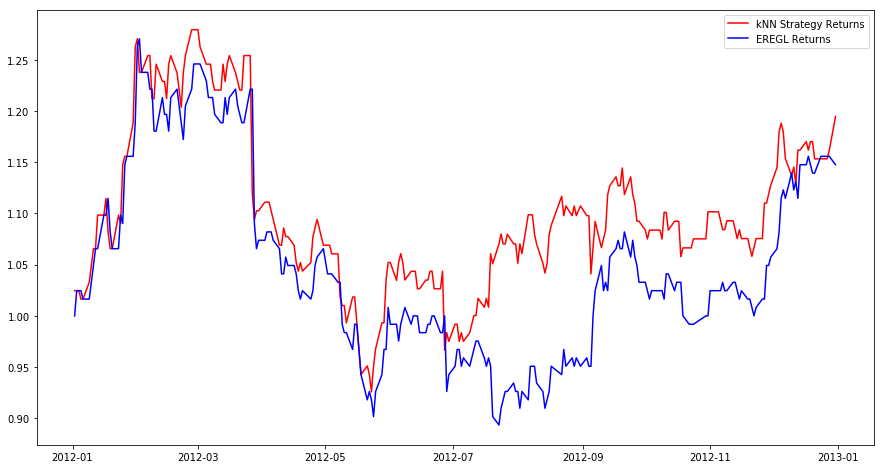

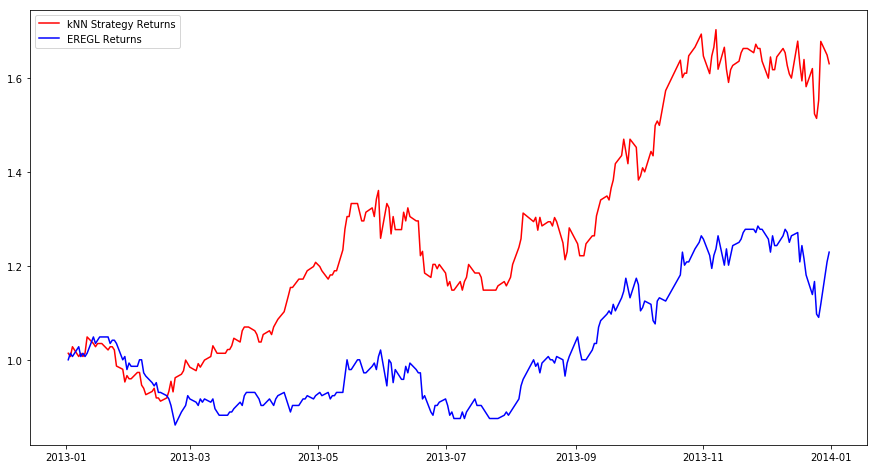

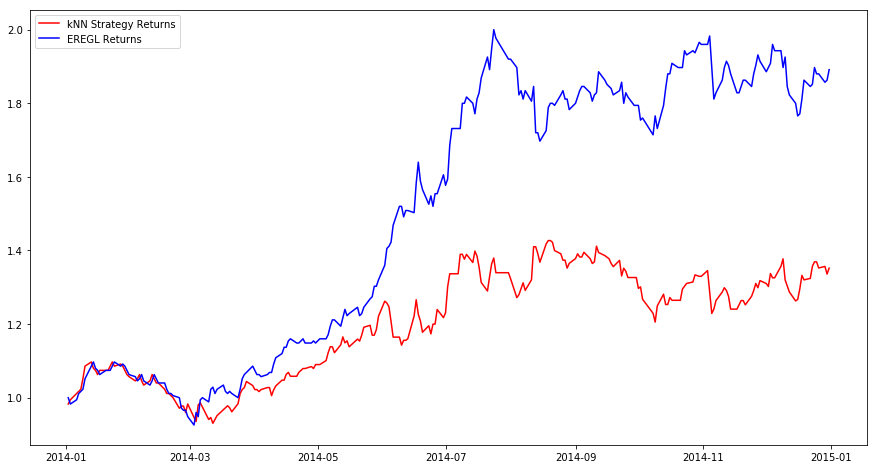

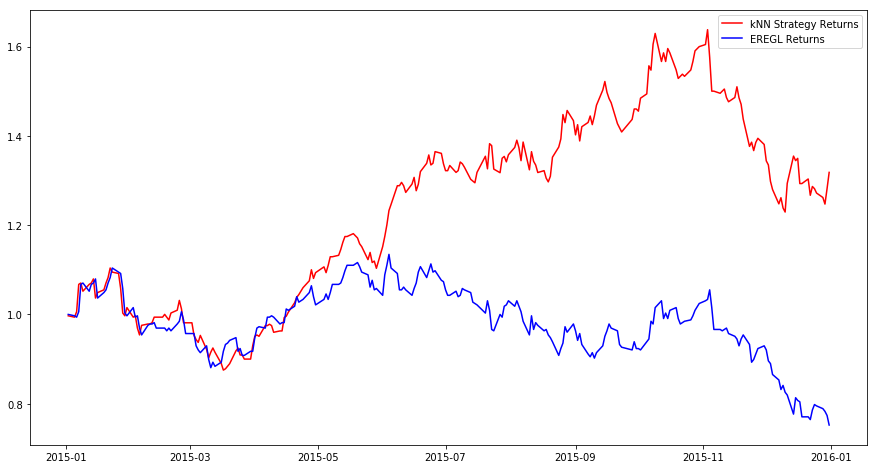

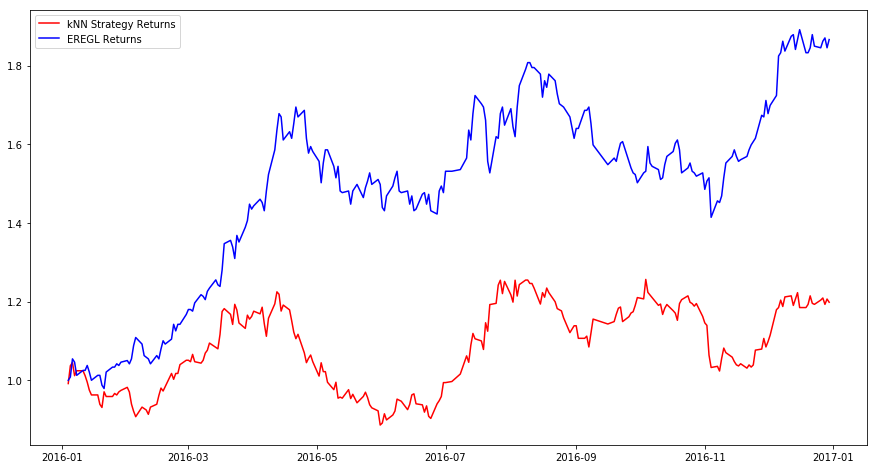

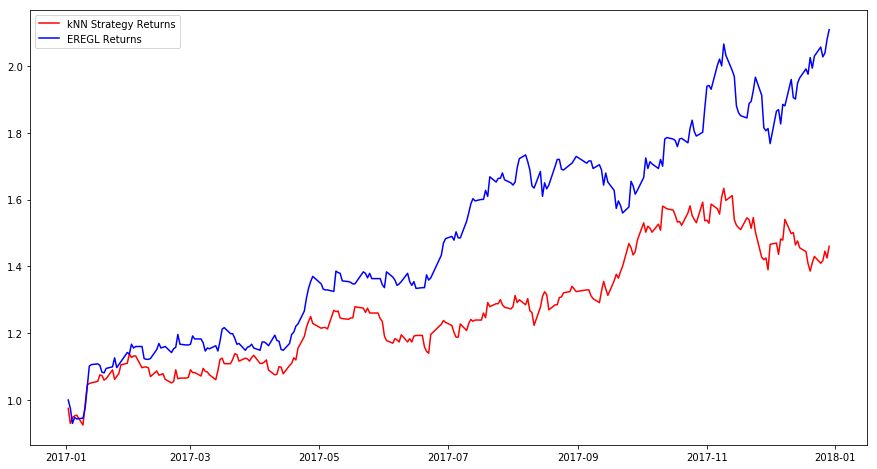

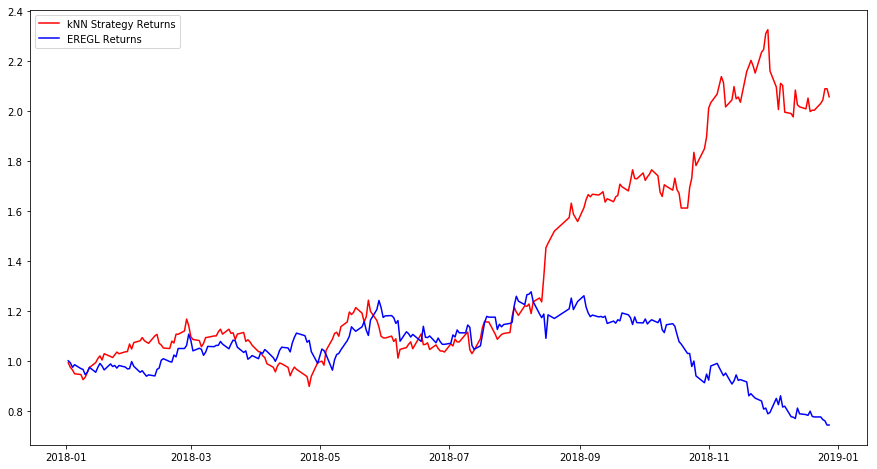

In [11]:
for i in range(2009,2016):
    plt.figure(figsize=(15,8))
    plt.plot(cumretsdic["cumrets{0}".format(i)], color ="r", label="kNN Strategy Returns")
    plt.plot(eregl[eregl.index.year==i+3]["Close"]/eregl[eregl.index.year==i+3]["Close"][0],color ="b", label="EREGL Returns")
    plt.legend()
    plt.show()

In [12]:
portretsall = pd.DataFrame()
for i in range(2009,2016):
    portrets = ypred_dic["ypred{0}".format(i)]*eregl[eregl.index.year==i+3]["ForwardReturns"]
    portrets = pd.DataFrame(portrets, index = eregl[eregl.index.year==i+3].index)
    portretsall = pd.concat([portretsall,portrets])

In [13]:
cumretsall = np.cumprod(1+portretsall["ForwardReturns"])

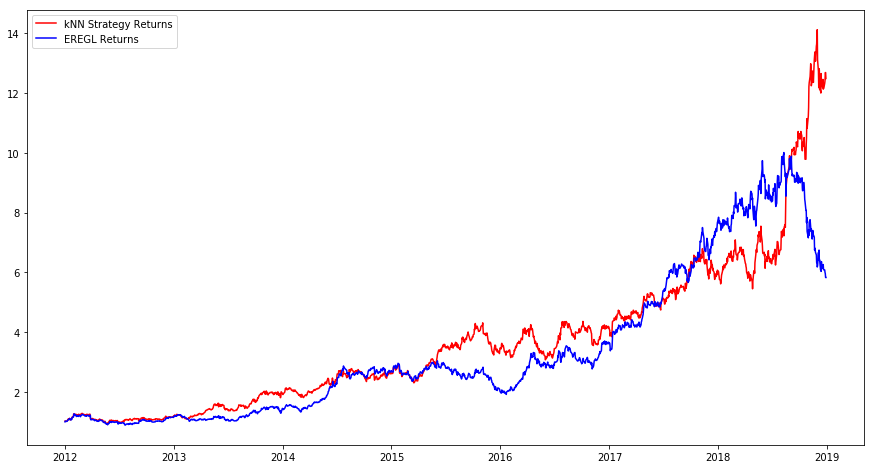

In [14]:
plt.figure(figsize=(15,8))
plt.plot(cumretsall, color ="r", label="kNN Strategy Returns")
plt.plot(eregl.loc["2012-01-02":,"Close"]/eregl.loc["2012-01-02":,"Close"][0],color ="b", label="EREGL Returns")
plt.legend()
plt.show()

In [15]:
# Classifier accuracy
print("Classifier Accuracy(%):",round(metrics.accuracy_score(np.concatenate(list(ytestdic.values())), np.concatenate(list(ypred_dic.values())))*100,2))
# Classifier precision
print("Classifier Precision(%):",round(metrics.precision_score(np.concatenate(list(ytestdic.values())), np.concatenate(list(ypred_dic.values())))*100,2))
#Difference to buy-and-hold
print("Difference to buy-and-hold(%):",round((cumretsall[-1]/(eregl.loc["2012-01-02":,"Close"]/eregl.loc["2012-01-02":,"Close"][0])[-1]-1)*100,2))

Classifier Accuracy(%): 55.59
Classifier Precision(%): 58.43
Difference to buy-and-hold(%): 114.27


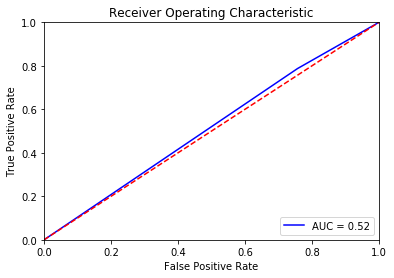

In [16]:
fpr, tpr, threshold = metrics.roc_curve(np.concatenate(list(ytestdic.values())), np.concatenate(list(ypred_dic.values())))
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [17]:
# Calculating error for K values between 1 and 50
meanerrors = []
allcumrets = []
for j in range(1, 51):
    error = []
    portretsall_j = pd.DataFrame()
    for i in range(2009,2016):
        knn = KNeighborsClassifier(n_neighbors=j)
        knn.fit(Xtraindic["X_train{0}".format(i)], ytraindic["y_train{0}".format(i)])
        pred_i = knn.predict(Xtestdic["X_test{0}".format(i)])
        error.append(np.mean(pred_i != ytestdic["y_test{0}".format(i)]))
        portrets_i = pred_i*eregl[eregl.index.year==i+3]["ForwardReturns"]
        portrets_i = pd.DataFrame(portrets_i, index = eregl[eregl.index.year==i+3].index)
        portretsall_j = pd.concat([portretsall_j,portrets_i])
    cumrets = (np.cumprod(1+portretsall_j["ForwardReturns"]))[-1]
    allcumrets.append(cumrets)
    meanerrors.append(np.mean(error))

Text(0, 0.5, 'Mean Error')

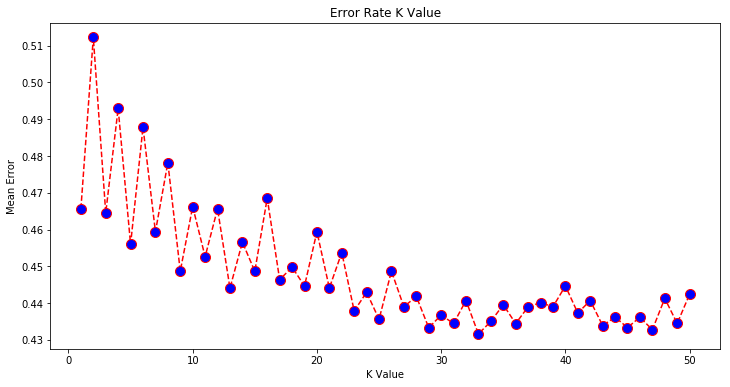

In [18]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 51), meanerrors, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

Text(0, 0.5, 'Difference to Buy-and-Hold (%)')

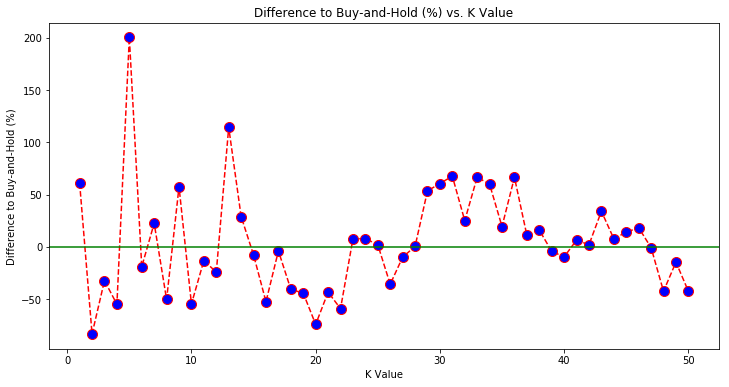

In [19]:
diffbh = (allcumrets/(eregl.loc["2012-01-02":,"Close"]/eregl.loc["2012-01-02":,"Close"][0])[-1]-1)*100
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 51), diffbh, color='red', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
plt.axhline(y=0, color='g', linestyle='-')
plt.title('Difference to Buy-and-Hold (%) vs. K Value')  
plt.xlabel('K Value')
plt.ylabel('Difference to Buy-and-Hold (%)')  

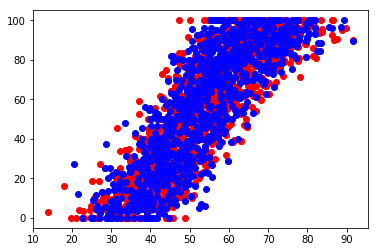

In [20]:
plt.plot(eregl.loc[eregl["ReturnSign"]==1,]["RSI"],eregl.loc[eregl["ReturnSign"]==1,]["%K"],"ro", label="Up")
plt.plot(eregl.loc[eregl["ReturnSign"]==-1,]["RSI"],eregl.loc[eregl["ReturnSign"]==-1,]["%K"],"bo", label="Down")

In [21]:
# Calculate Final Returns
print("Buy-and-hold return(%):", round(((eregl.loc["2012-01-02":,"Close"]/eregl.loc["2012-01-02":,"Close"][0])[-1]-1)*100,2))
print("kNN return(%):",round((cumretsall[-1]-1)*100,2))

Buy-and-hold return(%): 482.79
kNN return(%): 1148.71


In [22]:
### Calculate Performance and Risk Metrics
import empyrical as ep

## Buy-and-Hold
print("EREGL")
# CAGR
print("CAGR:",round(ep.annual_return(eregl.loc["2012-01-02":,"Returns"]),2))
# Annual Volatility
print("Annual Volatility:",round(ep.annual_volatility(eregl.loc["2012-01-02":,"Returns"]),2))
# Maximum Drawdown
print("Maximum Drawdown:",round(ep.max_drawdown(eregl.loc["2012-01-02":,"Returns"]),2))
# Sharpe Ratio
print("Sharpe Ratio:",round(ep.sharpe_ratio(eregl.loc["2012-01-02":,"Returns"]),2))
# Calmar Ratio
print("Calmar Ratio:",round(ep.calmar_ratio(eregl.loc["2012-01-02":,"Returns"]),2))

## k-NN
print("k-NN")
# CAGR
print("CAGR:",round(ep.annual_return(portretsall["ForwardReturns"]),2))
# Annual Volatility
print("Annual Volatility:",round(ep.annual_volatility(portretsall["ForwardReturns"]),2))
# Maximum Drawdown
print("Maximum Drawdown:",round(ep.max_drawdown(portretsall["ForwardReturns"]),2))
# Sharpe Ratio
print("Sharpe Ratio:",round(ep.sharpe_ratio(portretsall["ForwardReturns"]),2))
# Calmar Ratio
print("Calmar Ratio:",round(ep.calmar_ratio(portretsall["ForwardReturns"]),2))

EREGL
CAGR: 0.29
Annual Volatility: 0.32
Maximum Drawdown: -0.42
Sharpe Ratio: 0.96
Calmar Ratio: 0.69
k-NN
CAGR: 0.44
Annual Volatility: 0.32
Maximum Drawdown: -0.29
Sharpe Ratio: 1.3
Calmar Ratio: 1.52


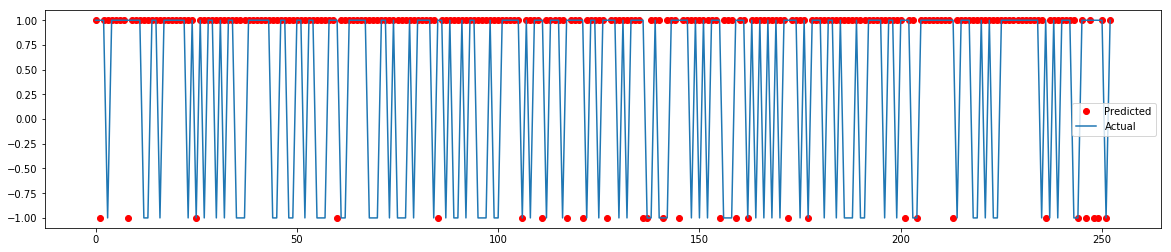

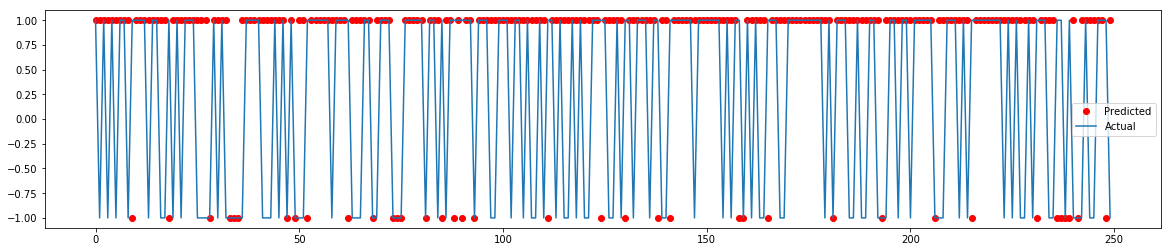

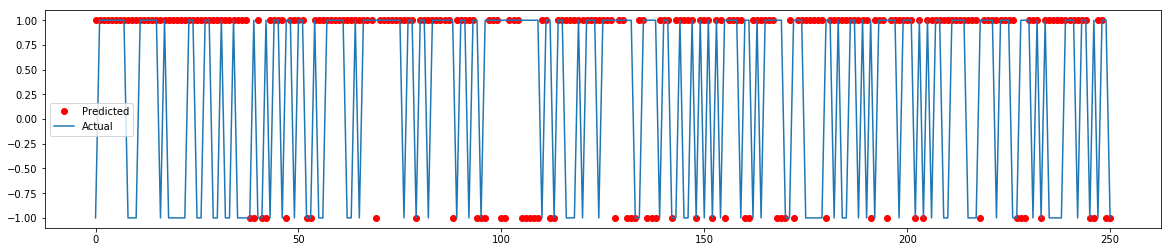

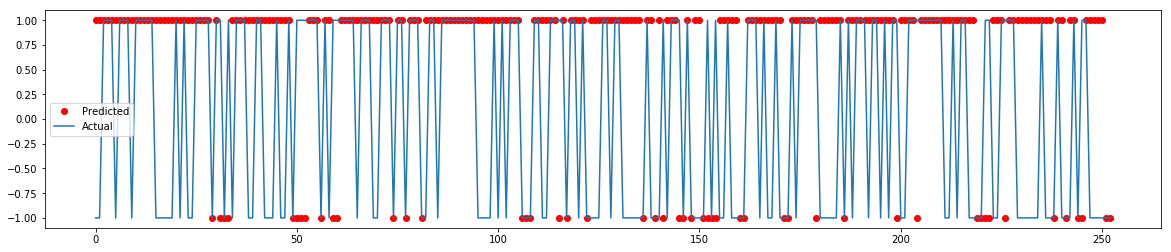

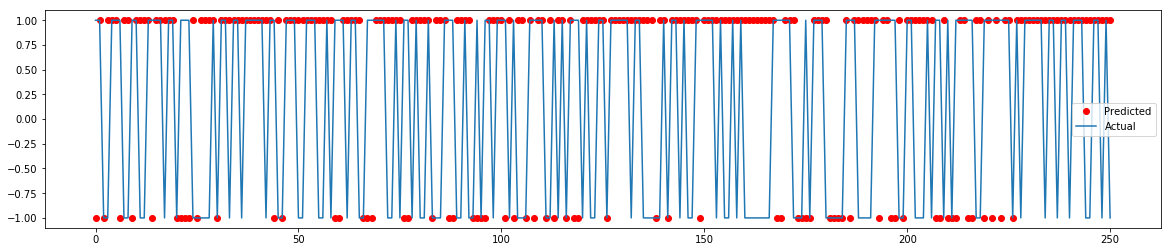

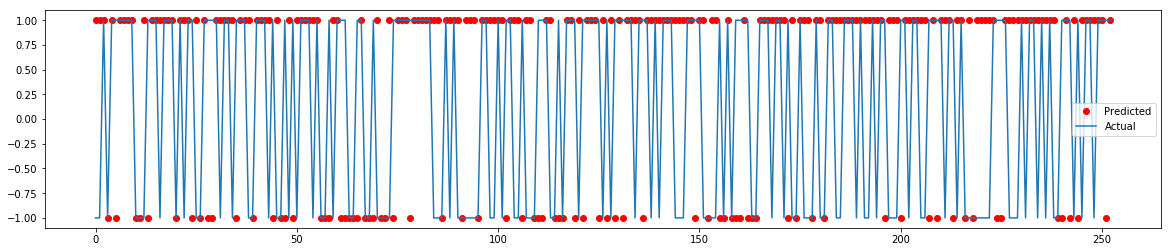

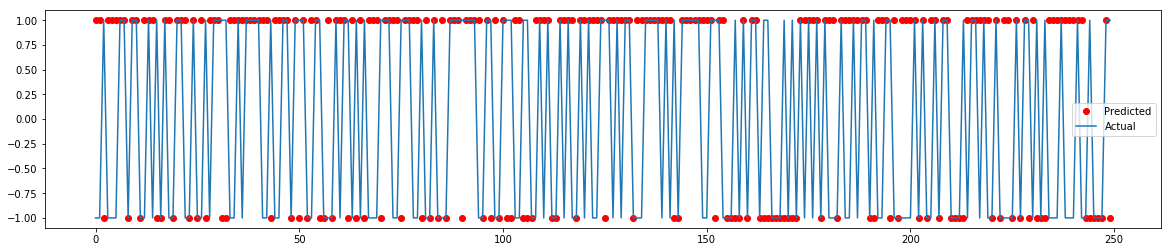

In [23]:
#Actual vs Predicted Graphs
for i in range(2009,2016):
    plt.figure(figsize=(20,4))  
    plt.plot(ypred_dic["ypred{0}".format(i)],"ro", label = "Predicted")
    plt.plot(ytestdic["y_test{0}".format(i)],label= "Actual")
    plt.legend()